In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils

import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
import cv2
import albumentations as A

from tqdm import tqdm
from torchvision.models import efficientnet_b0, mobilenet_v2, EfficientNet_B0_Weights, MobileNet_V2_Weights

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def get_augs(img):
    transform = A.Compose([
#         A.VerticalFlip(),
#         A.RandomRotate90(),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.CoarseDropout(max_height=5, max_width=5, min_holes=8, max_holes=32),

        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.2, rotate_limit=30, p=0.75),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
#             A.PiecewiseAffine(p=0.3),
        ], p=0.2),
        A.RandomBrightnessContrast(),            
    ])
    
    return transform(image=img)['image']

In [3]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [4]:
# load the dataset
training_dir = '/kaggle/input/ma-data/dataset/'
training_csv = '/kaggle/input/final-meta-ma/union_train_csv_7ksample_without_sames_imgs.csv'

validating_dir = '/kaggle/input/ma-data/dataset/'
validating_csv = '/kaggle/input/final-meta-ma/union_val_csv_2ksample_without_sames_imgs.csv'

testing_dir = '/kaggle/input/ma-data/dataset/'
testing_csv = '/kaggle/input/final-meta-ma/union_test_csv_1ksample.csv'


# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None, is_val=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)#.sample(15000, ignore_index=True)
#         self.train_df = training_csv
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform
        self.is_val = is_val

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = cv2.imread(image1_path)
        img1 = cv2.imread(image2_path)
        img0 = self.preprocess_img(img0)
        img1 = self.preprocess_img(img1)

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)
    
    
    def preprocess_img(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not self.is_val:
            img = get_augs(img)
        img = Image.fromarray(img)
        
        return img

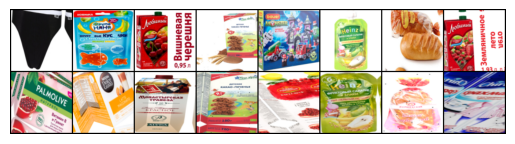

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [5]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
    

training_siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ), is_val=False
)

validating_siamese_dataset = SiameseDataset(
    validating_csv,
    validating_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ), is_val=True
)


# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(training_siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(3, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,16))
        
        
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [7]:
train_dataloader = DataLoader(training_siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=128)

valid_dataloader = DataLoader(validating_siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=128)

In [8]:
#Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
#Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

In [9]:
def train(train_dataloader):
    loss=[] 
    counter=[]
    iteration_number = 0
    
    net.train()
    for i, data in tqdm(enumerate(train_dataloader,0), desc='Training'):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(train_dataloader)


def evaluate(eval_dataloader):
    loss=[] 
    counter=[]
    iteration_number = 0
    
    true_predicts_05 = 0
    true_predicts_10 = 0
    true_predicts_15 = 0
    true_predicts_20 = 0
    true_predicts_25 = 0
    
    all_predicts = 0
    
    net.eval()
    for i, data in tqdm(enumerate(valid_dataloader,0), desc='Evaluating'):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        all_predicts += len(label)
        with torch.no_grad():
            output1,output2 = net(img0,img1)
        dists = F.pairwise_distance(output1, output2)

        for dist, true_label in zip(dists, torch.squeeze(data[2])):
            pred_05 = 0 if dist <= 0.05 else 1
            if pred_05 == int(true_label):
                true_predicts_05 += 1
            
            pred_10 = 0 if dist <= 0.10 else 1
            if pred_10 == int(true_label):
                true_predicts_10 += 1
            
            pred_15 = 0 if dist <= 0.15 else 1
            if pred_15 == int(true_label):
                true_predicts_15 += 1
                
            pred_20 = 0 if dist <= 0.20 else 1
            if pred_20 == int(true_label):
                true_predicts_20 += 1
                
            pred_25 = 0 if dist <= 0.25 else 1
            if pred_25 == int(true_label):
                true_predicts_25 += 1
                
        loss_contrastive = criterion(output1,output2,label)
        loss.append(loss_contrastive.item())
    loss = np.array(loss)
    all_acuracy = [round(true_predicts_05/all_predicts, 3), round(true_predicts_10/all_predicts, 3),
                   round(true_predicts_15/all_predicts, 3), round(true_predicts_20/all_predicts, 3),
                      round(true_predicts_25/all_predicts, 3)]
    
    return loss.mean()/len(eval_dataloader), all_acuracy

best_eval_accuracy = 0
for epoch in range(1,20):
    print('EPOCH --', epoch)
    
    train_loss = train(train_dataloader)
    eval_loss, eval_accuracy = evaluate(valid_dataloader)
    

    print(f"Training loss {train_loss}")
    print("-"*20)
    print(f"Eval loss {eval_loss}")
    print(f"Eval accuracy {eval_accuracy}")

    if max(eval_accuracy) > best_eval_accuracy:
        best_eval_accuracy = max(eval_accuracy)
        print("-"*20)
        print(f"Best Eval accuracy {best_eval_accuracy}")
        torch.save(net, f"./model_{epoch}.pth")
        print("Model Saved Successfully")
        best_epoch = epoch

EPOCH -- 1


Training: 0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Training: 55it [07:20,  8.01s/it]
Evaluating: 16it [00:20,  1.27s/it]


Training loss 0.10545208615705001
--------------------
Eval loss 0.12048854120075703
Eval accuracy [0.694, 0.763, 0.763, 0.711, 0.63]
--------------------
Best Eval accuracy 0.763
Model Saved Successfully
EPOCH -- 2


Training: 55it [07:06,  7.76s/it]
Evaluating: 16it [00:17,  1.07s/it]

Training loss 0.0190359184958718
--------------------
Eval loss 0.12078930018469691
Eval accuracy [0.7, 0.762, 0.743, 0.679, 0.615]
EPOCH -- 3



Training: 55it [07:10,  7.82s/it]
Evaluating: 16it [00:17,  1.09s/it]


Training loss 0.01896004739871695
--------------------
Eval loss 0.12319044722244143
Eval accuracy [0.709, 0.768, 0.727, 0.657, 0.589]
--------------------
Best Eval accuracy 0.768
Model Saved Successfully
EPOCH -- 4


Training: 55it [07:12,  7.86s/it]
Evaluating: 16it [00:17,  1.09s/it]

Training loss 0.018937500646291686
--------------------
Eval loss 0.12065711570903659
Eval accuracy [0.709, 0.755, 0.728, 0.673, 0.619]
EPOCH -- 5



Training: 55it [07:19,  7.99s/it]
Evaluating: 16it [00:17,  1.10s/it]

Training loss 0.01896478428328333
--------------------
Eval loss 0.12469206983223557
Eval accuracy [0.721, 0.754, 0.7, 0.618, 0.557]
EPOCH -- 6



Training: 55it [07:02,  7.68s/it]
Evaluating: 16it [00:16,  1.05s/it]

Training loss 0.01902540549759037
--------------------
Eval loss 0.12503665359690785
Eval accuracy [0.738, 0.7, 0.657, 0.616, 0.571]
EPOCH -- 7



Training: 55it [07:09,  7.81s/it]
Evaluating: 16it [00:18,  1.17s/it]

Training loss 0.019070501524554796
--------------------
Eval loss 0.12490459019318223
Eval accuracy [0.723, 0.754, 0.712, 0.637, 0.578]
EPOCH -- 8



Training: 55it [07:05,  7.73s/it]
Evaluating: 16it [00:16,  1.06s/it]

Training loss 0.018940508227702997
--------------------
Eval loss 0.12928187660872936
Eval accuracy [0.737, 0.748, 0.651, 0.56, 0.479]
EPOCH -- 9



Training: 55it [07:11,  7.85s/it]
Evaluating: 16it [00:17,  1.11s/it]

Training loss 0.018793019420844465
--------------------
Eval loss 0.12843432603403926
Eval accuracy [0.752, 0.729, 0.639, 0.573, 0.529]
EPOCH -- 10



Training: 55it [07:10,  7.83s/it]
Evaluating: 16it [00:17,  1.11s/it]

Training loss 0.01876736108921776
--------------------
Eval loss 0.1273693540133536
Eval accuracy [0.74, 0.748, 0.665, 0.587, 0.533]
EPOCH -- 11



Training: 55it [07:09,  7.82s/it]
Evaluating: 16it [00:17,  1.09s/it]

Training loss 0.018804795407066657
--------------------
Eval loss 0.12883419636636972
Eval accuracy [0.739, 0.737, 0.659, 0.569, 0.502]
EPOCH -- 12



Training: 55it [07:00,  7.64s/it]
Evaluating: 16it [00:16,  1.05s/it]

Training loss 0.019016755573020492
--------------------
Eval loss 0.12523819971829653
Eval accuracy [0.73, 0.74, 0.7, 0.634, 0.569]
EPOCH -- 13



Training: 55it [06:54,  7.54s/it]
Evaluating: 16it [00:17,  1.08s/it]

Training loss 0.018846398700367323
--------------------
Eval loss 0.12715749721974134
Eval accuracy [0.733, 0.73, 0.679, 0.619, 0.558]
EPOCH -- 14



Training: 55it [07:04,  7.72s/it]
Evaluating: 16it [00:16,  1.06s/it]

Training loss 0.018803899504921655
--------------------
Eval loss 0.12816664576530457
Eval accuracy [0.733, 0.715, 0.644, 0.571, 0.521]
EPOCH -- 15



Training: 55it [07:03,  7.70s/it]
Evaluating: 16it [00:16,  1.05s/it]

Training loss 0.018817452162750496
--------------------
Eval loss 0.12864119932055473
Eval accuracy [0.74, 0.732, 0.667, 0.588, 0.498]
EPOCH -- 16



Training: 55it [07:01,  7.67s/it]
Evaluating: 16it [00:18,  1.13s/it]

Training loss 0.018809251588238173
--------------------
Eval loss 0.1287605157122016
Eval accuracy [0.736, 0.718, 0.664, 0.595, 0.517]
EPOCH -- 17



Training: 55it [07:05,  7.74s/it]
Evaluating: 16it [00:17,  1.06s/it]

Training loss 0.01878049247521014
--------------------
Eval loss 0.1278415583074093
Eval accuracy [0.732, 0.698, 0.666, 0.621, 0.569]
EPOCH -- 18



Training: 55it [07:00,  7.65s/it]
Evaluating: 16it [00:16,  1.04s/it]

Training loss 0.018711718606554774
--------------------
Eval loss 0.12709586694836617
Eval accuracy [0.73, 0.723, 0.678, 0.622, 0.573]
EPOCH -- 19



Training: 55it [07:01,  7.67s/it]
Evaluating: 16it [00:17,  1.07s/it]

Training loss 0.019154063965663434
--------------------
Eval loss 0.12818717816844583
Eval accuracy [0.744, 0.725, 0.651, 0.573, 0.523]


In [10]:
torch.cuda.empty_cache()

/tmp/ipykernel_24/1283745191.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/kaggle/working/model_{best_epoch}.pth')
/opt/conda/lib/python3.10/site

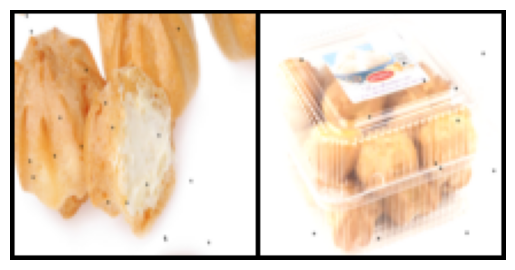

Predicted Eucledian Distance:- 0.07441502809524536
Actual Label:- Original Pair Of Signature


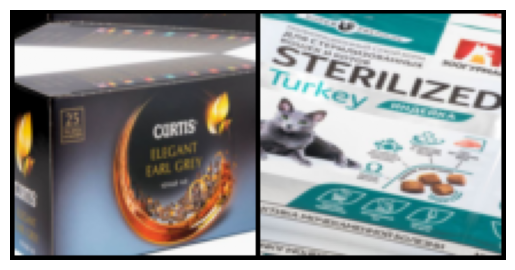

Predicted Eucledian Distance:- 0.3868674039840698
Actual Label:- Forged Pair Of Signature


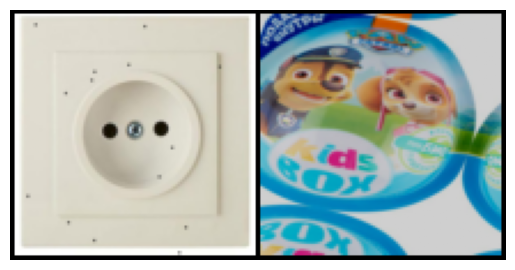

Predicted Eucledian Distance:- 0.18435858190059662
Actual Label:- Forged Pair Of Signature


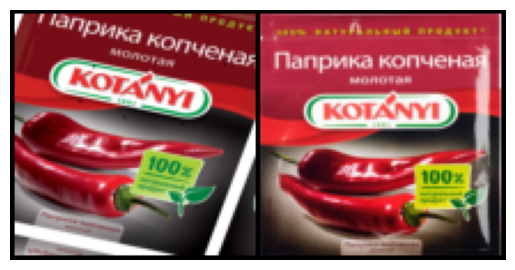

Predicted Eucledian Distance:- 0.06469164788722992
Actual Label:- Original Pair Of Signature


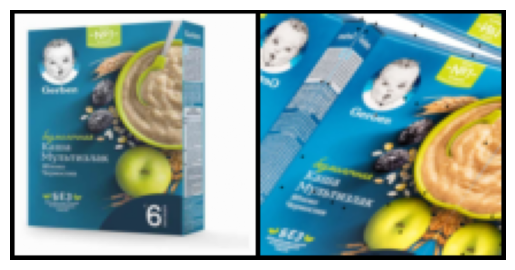

Predicted Eucledian Distance:- 0.11697699129581451
Actual Label:- Original Pair Of Signature


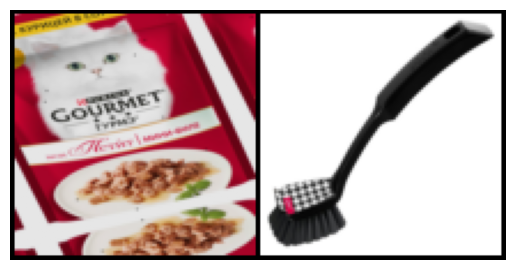

Predicted Eucledian Distance:- 0.16949881613254547
Actual Label:- Forged Pair Of Signature


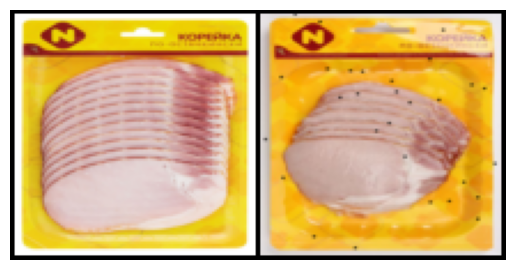

Predicted Eucledian Distance:- 0.09814814478158951
Actual Label:- Original Pair Of Signature


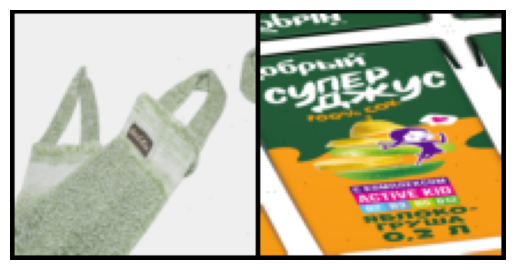

Predicted Eucledian Distance:- 0.2880127727985382
Actual Label:- Forged Pair Of Signature


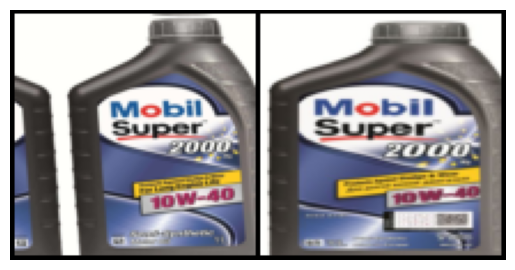

Predicted Eucledian Distance:- 0.06597010046243668
Actual Label:- Original Pair Of Signature


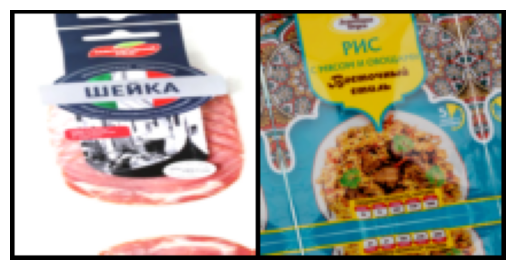

Predicted Eucledian Distance:- 0.26850631833076477
Actual Label:- Forged Pair Of Signature


In [11]:
model = torch.load(f'/kaggle/working/model_{best_epoch}.pth')

test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=True)

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to('cuda'), x1.to('cuda'))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break

In [12]:
test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ), is_val=True
)

test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=False)


eucledian_distances = []
true_labels = []

for i, data in tqdm(enumerate(test_dataloader, 0), desc='getting test metrics'):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to('cuda'), x1.to('cuda'))

    eucledian_distance = F.pairwise_distance(output1, output2)
    
    true_labels.append(int(label))
    eucledian_distances.append(eucledian_distance.cpu().detach().numpy()[0])

getting test metrics: 0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
getting test metrics: 1000it [00:15, 65.69it/s]


In [13]:
test_results = pd.DataFrame()
test_results['true_label'] = true_labels
test_results['eucledian_distance'] = eucledian_distances
test_results['predict_labels'] = (test_results['eucledian_distance'] < 0.1).apply(lambda x: not x).astype(int)

print(test_results[test_results['true_label'] == test_results['predict_labels']].shape[0] / test_results.shape[0])

0.76


In [14]:
test_results['predict_labels'] = (test_results['eucledian_distance'] < 0.15).apply(lambda x: not x).astype(int)

print(test_results[test_results['true_label'] == test_results['predict_labels']].shape[0] / test_results.shape[0])

0.767


In [15]:
test_results['predict_labels'] = (test_results['eucledian_distance'] < 0.05).apply(lambda x: not x).astype(int)

print(test_results[test_results['true_label'] == test_results['predict_labels']].shape[0] / test_results.shape[0])

0.656


In [16]:
test_results['predict_labels'] = (test_results['eucledian_distance'] < 0.2).apply(lambda x: not x).astype(int)

print(test_results[test_results['true_label'] == test_results['predict_labels']].shape[0] / test_results.shape[0])

0.717


8 out neuro - 0.792